# Simulation 4: Additive Trigonometric, uniform

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.model_selection import cross_val_score
from scipy.linalg import toeplitz

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

### Random Feature

In [2]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

### Fitting

In [3]:
class MultilayerFitting:
    """Multi-layer Fitting

    Parameters
    ----------
    model_fit : 
        chosen network structure
    device_fit : {"cpu", "cuda"}
    train_loader_fit : dataloader
        training data
    test_loader_fit : dataloader
        test data
    epochs_fit : int
        maximum epoch number
    criterion_fit : 
        chosen criterion
    optimizer_fit : 
        chosen optimizer
    terminate_fit : int
        terminate parameter
    print_fit : 
        print parameter
    printchoice : bool
        print results or not
    """
    
    def __init__(self, model_fit,device_fit,train_loader_fit,
                 epochs_fit, criterion_fit, optimizer_fit, 
                 terminate_fit=2000, print_fit=500,printchoice=True):
        self.model_fit = model_fit
        self.device_fit = device_fit
        self.train_loader_fit = train_loader_fit
        self.epochs_fit = epochs_fit
        self.criterion_fit = criterion_fit
        self.optimizer_fit = optimizer_fit
        self.terminate_fit = terminate_fit
        self.print_fit = print_fit
        self.printchoice = printchoice
        
    def fitting(self,train_x,train_y,test_x,test_y):
        """Fitting procedure

        Parameters
        -------
        train_x : DataFrame
        train_y : Series
        test_x : DataFrame
        test_y : Series
            global data
        batch : int
            batch size

        Returns
        -------
        trainloss : list
            trainning loss
        testloss : list
            test loss
        prediction : list
            model prediction for test data
        """
        
        trainloss=[]
        testloss=[]
        t0=time.time()
        net_fit = self.model_fit
        net_fit = net_fit.to(self.device_fit)
        for epoch in range(self.epochs_fit): 
            for x, y in self.train_loader_fit: #for batch, (x, y) in enumerate(train_loader): 
                x, y = x.to(self.device_fit), y.to(self.device_fit)
                # Compute prediction error
                y_pred = net_fit(x)
                y_pred = torch.squeeze(y_pred)
                train_loss = self.criterion_fit(y_pred, y)
                # Backpropagation
                self.optimizer_fit.zero_grad() 
                train_loss.backward()
                self.optimizer_fit.step()
            
            x0=torch.from_numpy(train_x[:]).float()
            with torch.no_grad():
                x0 = x0.to(self.device_fit)
                pred = net_fit(x0)
            trainloss.append(mean_squared_error(pred,train_y))
            
            x1=torch.from_numpy(test_x[:]).float()
            with torch.no_grad():
                x1 = x1.to(self.device_fit)
                pred = net_fit(x1)
            testloss.append(mean_squared_error(pred,test_y))
            
            if epoch>self.terminate_fit and float(trainloss[-1])>max(trainloss[-self.terminate_fit:-1]):
                break
            
            if epoch % self.print_fit == 0 and self.printchoice==True:         
                print(f'''epoch {epoch}
                    Train set - loss: {trainloss[-1]}
                    Test  set - loss: {testloss[-1]}
                    ''')
            
            
        if self.printchoice==True:              
            fit = time.time() - t0
            print("Model fitted in %.3f s" % fit)
        
        
        x0=torch.from_numpy(test_x).float()
        with torch.no_grad():
            x0 = x0.to(self.device_fit)
            pred = net_fit(x0)
            pred = torch.Tensor.cpu(pred)
            prediction=np.array(pred).reshape(-1)
        
        return(trainloss,testloss,prediction)

### Dataset

In [4]:
class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)
    def __getitem__(self, item): 
        return self._x[item], self._y[item]
    def __len__(self):
        return self._len

In [5]:
mse_result = pd.DataFrame(
    columns=['DNN', 'ResNet', 'MLKM', 'RKM'],
    index=[
        'd=1', 'd=2', 'd=5', 'd=10'
    ],
    dtype=float)

## 1. DNN

d=1
epoch 0
                    Train set - loss: 0.6107148546567175
                    Test  set - loss: 0.606438603818338
                    
epoch 500
                    Train set - loss: 8.367739319724158e-05
                    Test  set - loss: 8.02441112967954e-05
                    
epoch 1000
                    Train set - loss: 8.174943149340881e-05
                    Test  set - loss: 7.818925416508799e-05
                    
epoch 1500
                    Train set - loss: 8.208320534789619e-05
                    Test  set - loss: 7.841336245309913e-05
                    
epoch 2000
                    Train set - loss: 8.223421940445314e-05
                    Test  set - loss: 7.844210392644996e-05
                    
epoch 2500
                    Train set - loss: 8.226150423642745e-05
                    Test  set - loss: 7.865040355123238e-05
                    
epoch 3000
                    Train set - loss: 8.22656779849065e-05
                    Test  

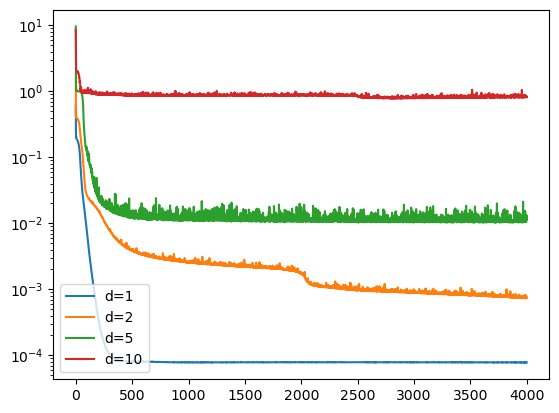

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(p, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)
        self.fc5 = nn.Linear(10, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)
    
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)


### data
n=1000
plist=[1,2,5,10]
losslist=[]
for p in plist:
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=3e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)

    dnn_model=MultilayerFitting(net,device,train_loader, 4000, criterion, optimizer,2000)
    dnn_trainloss,dnn_testloss,prediction=dnn_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(dnn_trainloss[-1],dnn_testloss[-1]))
    losslist.append(dnn_testloss[-1])
    plt.plot(dnn_testloss,label="d={:d}".format(p))
    plt.yscale('log')
plt.legend()
plt.show()
mse_result['DNN']=losslist

## 2. ResNet

d=1
epoch 0
                    Train set - loss: 0.549232712584773
                    Test  set - loss: 0.5457483203943937
                    
epoch 500
                    Train set - loss: 4.017704647395357e-05
                    Test  set - loss: 4.110351336719203e-05
                    
epoch 1000
                    Train set - loss: 3.975549051882679e-05
                    Test  set - loss: 4.0316505711494895e-05
                    
epoch 1500
                    Train set - loss: 4.0429927245820926e-05
                    Test  set - loss: 4.112653492810915e-05
                    
epoch 2000
                    Train set - loss: 4.102601964078555e-05
                    Test  set - loss: 4.1878661026653555e-05
                    
epoch 2500
                    Train set - loss: 4.1283593134097655e-05
                    Test  set - loss: 4.205768531853271e-05
                    
epoch 3000
                    Train set - loss: 4.1501546385773554e-05
                   

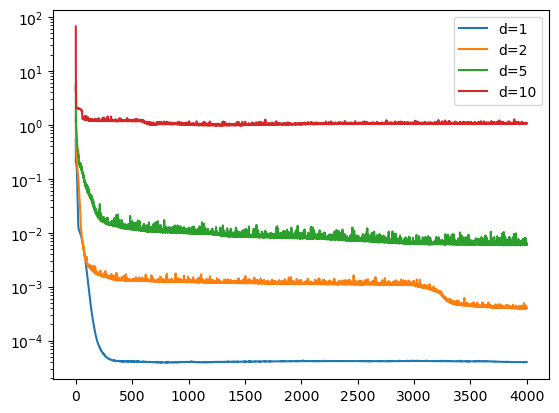

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(p,10)
        self.rblock2 = ResidualBlock(10,10)
        self.rblock3 = ResidualBlock(10,10)
        self.rblock4 = ResidualBlock(10,10)
        self.fc5 = nn.Linear(10,1)
    
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.rblock3(x)
        x = self.rblock4(x)
        return self.fc5(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)


### data
n=1000
plist=[1,2,5,10]
losslist=[]
for p in plist:
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=3e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)
    
    res_model=MultilayerFitting(net,device,train_loader, 4000, criterion, optimizer,2000)
    res_trainloss,res_testloss,prediction=res_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(res_trainloss[-1],res_testloss[-1]))
    losslist.append(res_testloss[-1])
    plt.plot(res_testloss,label="d={:d}".format(p))
    plt.yscale('log')
plt.legend()
plt.show()
mse_result['ResNet']=losslist

# 3. MLKM

d=1
epoch 0
                    Train set - loss: 0.6677435904257538
                    Test  set - loss: 0.6631834318746785
                    
epoch 500
                    Train set - loss: 0.0018189356021984524
                    Test  set - loss: 0.0018348952444273436
                    
epoch 1000
                    Train set - loss: 1.2851246151148788e-05
                    Test  set - loss: 1.3714537202386407e-05
                    
epoch 1500
                    Train set - loss: 6.695652062480922e-06
                    Test  set - loss: 6.963989212774733e-06
                    
epoch 2000
                    Train set - loss: 5.938150611701155e-06
                    Test  set - loss: 6.335499576160175e-06
                    
epoch 2500
                    Train set - loss: 5.54501188516201e-06
                    Test  set - loss: 5.862544374681189e-06
                    
epoch 3000
                    Train set - loss: 6.707734033169538e-06
                    Te

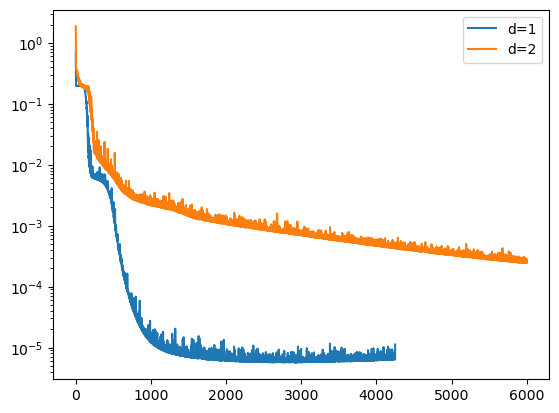

In [61]:
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=-0.1)
        m.bias.data.fill_(0.01)
        
### data
n=1000
plist=[1,2]
losslist=[]
for p in plist:
    rff1=RandomFourierFeature(p,10,kernel='G',gamma=0.5)
    rff2=RandomFourierFeature(10,10,kernel='G',gamma=1)
    rff3=RandomFourierFeature(10,10,kernel='G',gamma=2)
    rff4=RandomFourierFeature(10,10,kernel='G',gamma=4)

    class KernelNet(nn.Module): 
        def __init__(self):
            super(KernelNet, self).__init__()
            self.fc1 = nn.Linear(10, 10)
            self.fc2 = nn.Linear(10, 10)
            self.fc3 = nn.Linear(10, 10)
            self.fc4 = nn.Linear(10, 1)
            
        def forward(self, x):
            x = rff1.transform(x)
            x=self.fc1(x)
            x = rff2.transform(x)
            x=self.fc2(x)
            x = rff3.transform(x)
            x=self.fc3(x)
            x = rff4.transform(x)
            return self.fc4(x)
        

    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)
    
    
    kernelnn_model=MultilayerFitting(net,device,train_loader, 6000, criterion, optimizer,2000)
    kernelnn_trainloss,kernelnn_testloss,prediction=kernelnn_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(kernelnn_trainloss[-1],kernelnn_testloss[-1]))
    losslist.append(kernelnn_testloss[-1])
    plt.plot(kernelnn_testloss,label="d={:d}".format(p))
    plt.yscale('log')

plt.legend()
plt.show()
mse_result['MLKM'][0:2]=losslist

d=5
epoch 0
                    Train set - loss: 15.752914740149889
                    Test  set - loss: 15.69931756847502
                    
epoch 500
                    Train set - loss: 0.048700628422879075
                    Test  set - loss: 0.06001293536777135
                    
epoch 1000
                    Train set - loss: 0.03405563008877159
                    Test  set - loss: 0.04974464966946809
                    
epoch 1500
                    Train set - loss: 0.04361521559869516
                    Test  set - loss: 0.056726765224425206
                    
epoch 2000
                    Train set - loss: 0.035734177785465275
                    Test  set - loss: 0.052434995384493616
                    
epoch 2500
                    Train set - loss: 0.031858105285347646
                    Test  set - loss: 0.04775393102746868
                    
epoch 3000
                    Train set - loss: 0.023367117519837836
                    Test  set - loss: 0.

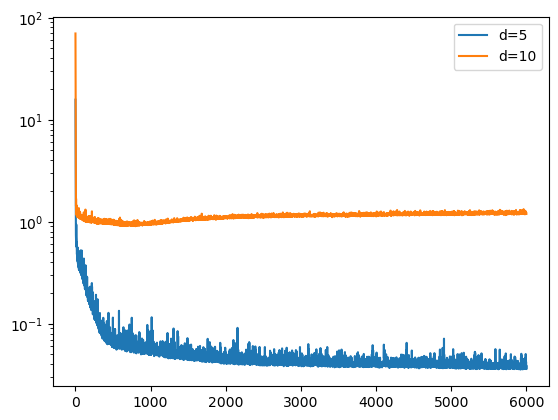

In [84]:
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)
        
### data
n=1000
plist=[5,10]
losslist=[]
for p in plist:
    rff1=RandomFourierFeature(p,10,kernel='G',gamma=0.5)
    rff2=RandomFourierFeature(10,10,kernel='G',gamma=1)
    rff3=RandomFourierFeature(10,10,kernel='G',gamma=2)
    rff4=RandomFourierFeature(10,10,kernel='G',gamma=4)

    class KernelNet(nn.Module): 
        def __init__(self):
            super(KernelNet, self).__init__()
            self.fc1 = nn.Linear(10, 10)
            self.fc2 = nn.Linear(10, 10)
            self.fc3 = nn.Linear(10, 10)
            self.fc4 = nn.Linear(10, 1)
            
        def forward(self, x):
            x = rff1.transform(x)
            x=self.fc1(x)
            x = rff2.transform(x)
            x=self.fc2(x)
            x = rff3.transform(x)
            x=self.fc3(x)
            x = rff4.transform(x)
            return self.fc4(x)
        

    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)
    
    
    kernelnn_model=MultilayerFitting(net,device,train_loader, 6000, criterion, optimizer,4000)
    kernelnn_trainloss,kernelnn_testloss,prediction=kernelnn_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(kernelnn_trainloss[-1],kernelnn_testloss[-1]))
    losslist.append(kernelnn_testloss[-1])
    plt.plot(kernelnn_testloss,label="d={:d}".format(p))
    plt.yscale('log')

plt.legend()
plt.show()
mse_result['MLKM'][2:]=losslist

# 4. RKM

d=1
epoch 0
                    Train set - loss: 0.11035760378269296
                    Test  set - loss: 0.10716608004316396
                    
epoch 500
                    Train set - loss: 0.0001014800231606291
                    Test  set - loss: 0.00010237847568135347
                    
epoch 1000
                    Train set - loss: 5.878316638815338e-05
                    Test  set - loss: 5.958278609240081e-05
                    
epoch 1500
                    Train set - loss: 4.94433936314828e-05
                    Test  set - loss: 5.0261680618429975e-05
                    
epoch 2000
                    Train set - loss: 4.451761504752246e-05
                    Test  set - loss: 4.5285734909237806e-05
                    
epoch 2500
                    Train set - loss: 4.4129122668533524e-05
                    Test  set - loss: 4.4081970109702124e-05
                    
epoch 3000
                    Train set - loss: 4.390960086986409e-05
                 

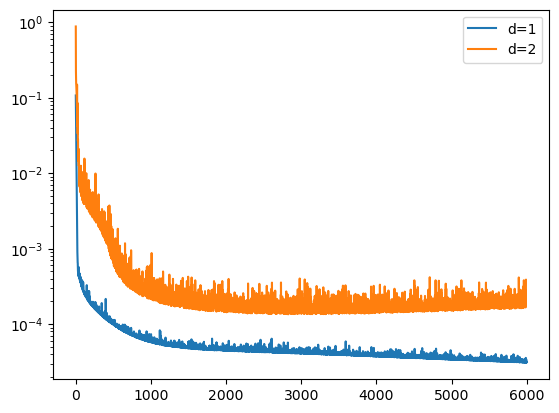

In [83]:
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)
        
### data
n=1000
plist=[1,2]
losslist=[]
for p in plist:
    rff0=RandomFourierFeature(p,10,kernel='G',gamma=0.5)
    rff1=RandomFourierFeature(10,10,kernel='G',gamma=1)
    rff2=RandomFourierFeature(10,10,kernel='G',gamma=2)
    rff3=RandomFourierFeature(10,10,kernel='G',gamma=4)

    class ResidualBlock(nn.Module):
        def __init__(self,infeatures,outfeatures,rff):
            super(ResidualBlock,self).__init__()
            self.infeatures = infeatures
            self.outfeatures = outfeatures
            self.rff=rff
            
            self.fc1 = nn.Linear(infeatures,outfeatures)
            self.fc2 = nn.Linear(outfeatures,outfeatures)
        
        def forward(self, x):
            rff=self.rff
            x = self.fc1(x)
            y = rff.transform(x)
            y = self.fc2(y)
            return x+y

    class ResKernelNet(nn.Module): 
        def __init__(self):
            super(ResKernelNet, self).__init__()
            self.rblock1 = ResidualBlock(10,10,rff1)
            self.rblock2 = ResidualBlock(10,10,rff2)
            self.rblock3 = ResidualBlock(10,10,rff3)
            self.fc4 =nn.Linear(10,1)
    
        def forward(self, x):
            x = rff0.transform(x)
            x = self.rblock1(x)
            x = self.rblock2(x)
            x = self.rblock3(x)
            return self.fc4(x)
    
    
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
    
    if p==10:
        def init_weights(m):
            if type(m) == nn.Conv2d:
                torch.nn.init.normal_(m.weight,mean=0,std=0.5)
            if type(m) == nn.Linear:
                torch.nn.init.uniform_(m.weight,a=-0.05,b=-0.05)
                m.bias.data.fill_(0.01)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)
    
    reskernel_model=MultilayerFitting(net,device,train_loader, 6000, criterion, optimizer,3000)
    reskernel_trainloss,reskernel_testloss,prediction=reskernel_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(kernelnn_trainloss[-1],reskernel_testloss[-1]))
    losslist.append(reskernel_testloss[-1])
    plt.plot(reskernel_testloss,label="d={:d}".format(p))
    plt.yscale('log')
    
plt.legend()
plt.show()
mse_result['RKM'][0:2]=losslist

d=5
epoch 0
                    Train set - loss: 4.43893945669491
                    Test  set - loss: 4.385386518459592
                    
epoch 500
                    Train set - loss: 0.03185188934607298
                    Test  set - loss: 0.041609599877849006
                    
epoch 1000
                    Train set - loss: 0.019874699457413172
                    Test  set - loss: 0.029592962647493296
                    
epoch 1500
                    Train set - loss: 0.015048033706442454
                    Test  set - loss: 0.02500746124589828
                    
epoch 2000
                    Train set - loss: 0.014053506390415558
                    Test  set - loss: 0.02516425093740787
                    
epoch 2500
                    Train set - loss: 0.01380730275041206
                    Test  set - loss: 0.023027250160446384
                    
epoch 3000
                    Train set - loss: 0.016159336070725935
                    Test  set - loss: 0.0

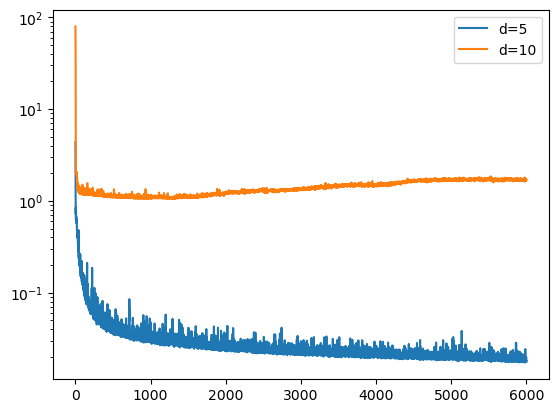

In [87]:
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)
        
### data
n=1000
plist=[5,10]
losslist=[]
for p in plist:
    rff0=RandomFourierFeature(p,10,kernel='G',gamma=0.5)
    rff1=RandomFourierFeature(10,10,kernel='G',gamma=1)
    rff2=RandomFourierFeature(10,10,kernel='G',gamma=2)
    rff3=RandomFourierFeature(10,10,kernel='G',gamma=4)

    class ResidualBlock(nn.Module):
        def __init__(self,infeatures,outfeatures,rff):
            super(ResidualBlock,self).__init__()
            self.infeatures = infeatures
            self.outfeatures = outfeatures
            self.rff=rff
            
            self.fc1 = nn.Linear(infeatures,outfeatures)
            self.fc2 = nn.Linear(outfeatures,outfeatures)
        
        def forward(self, x):
            rff=self.rff
            x = self.fc1(x)
            y = rff.transform(x)
            y = self.fc2(y)
            return x+y

    class ResKernelNet(nn.Module): 
        def __init__(self):
            super(ResKernelNet, self).__init__()
            self.rblock1 = ResidualBlock(10,10,rff1)
            self.rblock2 = ResidualBlock(10,10,rff2)
            self.rblock3 = ResidualBlock(10,10,rff3)
            self.fc4 =nn.Linear(10,1)
    
        def forward(self, x):
            x = rff0.transform(x)
            x = self.rblock1(x)
            x = self.rblock2(x)
            x = self.rblock3(x)
            return self.fc4(x)
    
    
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
    
    if p==10:
        def init_weights(m):
            if type(m) == nn.Conv2d:
                torch.nn.init.normal_(m.weight,mean=0,std=0.5)
            if type(m) == nn.Linear:
                torch.nn.init.uniform_(m.weight,a=-0.05,b=-0.05)
                m.bias.data.fill_(0.01)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)
    
    reskernel_model=MultilayerFitting(net,device,train_loader, 6000, criterion, optimizer,4000)
    reskernel_trainloss,reskernel_testloss,prediction=reskernel_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(kernelnn_trainloss[-1],reskernel_testloss[-1]))
    losslist.append(reskernel_testloss[-1])
    plt.plot(reskernel_testloss,label="d={:d}".format(p))
    plt.yscale('log')
    
plt.legend()
plt.show()
mse_result['RKM'][2:]=losslist

comparison

In [89]:
mse_result

,DNN,ResNet,MLKM,RKM
d=1,0.000078,0.000040,0.000011,0.000031
d=2,0.000738,0.000407,0.000277,0.000386
d=5,0.012903,0.005950,0.036259,0.018045
d=10,0.817243,1.069396,1.191526,1.686899


## High

In [33]:
mse_high_result = pd.DataFrame(
    columns=['DNN', 'ResNet', 'MLKM', 'RKM'],
    index=[
        'd=100', 'd=1000'
    ],
    dtype=float)

## 1. DNN

d=100
epoch 0
                    Train set - loss: 77.00850554616417
                    Test  set - loss: 77.91720810985984
                    
epoch 500
                    Train set - loss: 0.9037315967183236
                    Test  set - loss: 1.5534619292046714
                    
epoch 1000
                    Train set - loss: 0.5494199966532752
                    Test  set - loss: 1.8326790254421303
                    
epoch 1500
                    Train set - loss: 0.2815376531987348
                    Test  set - loss: 2.4651021825824357
                    
epoch 2000
                    Train set - loss: 0.1833740345337645
                    Test  set - loss: 2.878238067471465
                    
epoch 2500
                    Train set - loss: 0.13436988530024807
                    Test  set - loss: 3.1355421556574954
                    
epoch 3000
                    Train set - loss: 0.10036102158655634
                    Test  set - loss: 3.219843269692579

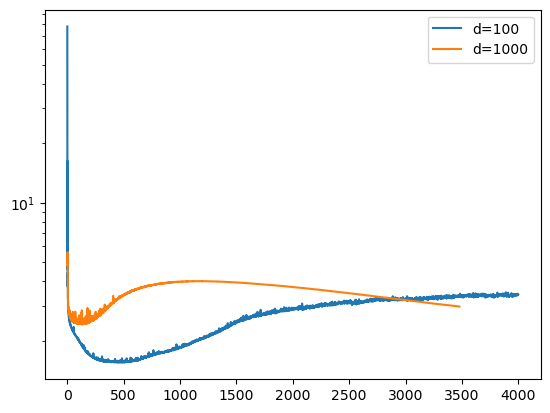

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(p, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)
        self.fc5 = nn.Linear(10, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)
    
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)


### data
n=1000
plist=[100,1000]
losslist=[]
for p in plist:
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-2) 

    dnn_model=MultilayerFitting(net,device,train_loader, 4000, criterion, optimizer,2000)
    dnn_trainloss,dnn_testloss,prediction=dnn_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(dnn_trainloss[-1],dnn_testloss[-1]))
    losslist.append(dnn_testloss[-1])
    plt.plot(dnn_testloss,label="d={:d}".format(p))
    plt.yscale('log')
plt.legend()
plt.show()
mse_high_result['DNN']=losslist

## 2. ResNet

d=100
epoch 0
                    Train set - loss: 42.610103733805985
                    Test  set - loss: 44.93841956951075
                    
epoch 500
                    Train set - loss: 0.5202018986955674
                    Test  set - loss: 2.1408868131333385
                    
epoch 1000
                    Train set - loss: 0.1407874771556961
                    Test  set - loss: 2.7679322007484575
                    
epoch 1500
                    Train set - loss: 0.05558668547070004
                    Test  set - loss: 3.1971398936586084
                    
epoch 2000
                    Train set - loss: 0.032956146092544485
                    Test  set - loss: 3.3360274009371724
                    
epoch 2500
                    Train set - loss: 0.016148926797920616
                    Test  set - loss: 3.340877082941929
                    
epoch 3000
                    Train set - loss: 0.04118720189605019
                    Test  set - loss: 3.3523396552

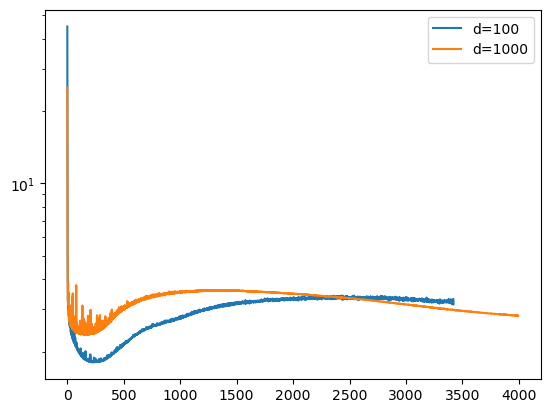

In [35]:
class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(p,10)
        self.rblock2 = ResidualBlock(10,10)
        self.rblock3 = ResidualBlock(10,10)
        self.rblock4 = ResidualBlock(10,10)
        self.fc5 = nn.Linear(10,1)
    
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.rblock3(x)
        x = self.rblock4(x)
        return self.fc5(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)


### data
n=1000
plist=[100,1000]
losslist=[]
for p in plist:
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=5e-4,momentum=0.9,weight_decay=1e-2) 

    res_model=MultilayerFitting(net,device,train_loader, 4000, criterion, optimizer,2000)
    res_trainloss,res_testloss,prediction=res_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(res_trainloss[-1],res_testloss[-1]))
    losslist.append(res_testloss[-1])
    plt.plot(res_testloss,label="d={:d}".format(p))
    plt.yscale('log')
plt.legend()
plt.show()
mse_high_result['ResNet']=losslist

## 3. MLKM

d=100
epoch 0
                    Train set - loss: 86.3283048064787
                    Test  set - loss: 87.35491811191524
                    
epoch 500
                    Train set - loss: 1.879566870227646
                    Test  set - loss: 2.187941488526436
                    
epoch 1000
                    Train set - loss: 1.7883908053139375
                    Test  set - loss: 2.282184337820186
                    
epoch 1500
                    Train set - loss: 1.741996816968777
                    Test  set - loss: 2.363071489169247
                    
epoch 2000
                    Train set - loss: 1.7100859762451046
                    Test  set - loss: 2.4150944576117066
                    
epoch 2500
                    Train set - loss: 1.660203201709972
                    Test  set - loss: 2.491299349489648
                    
epoch 3000
                    Train set - loss: 1.5703644647449388
                    Test  set - loss: 2.4977056138576144
       

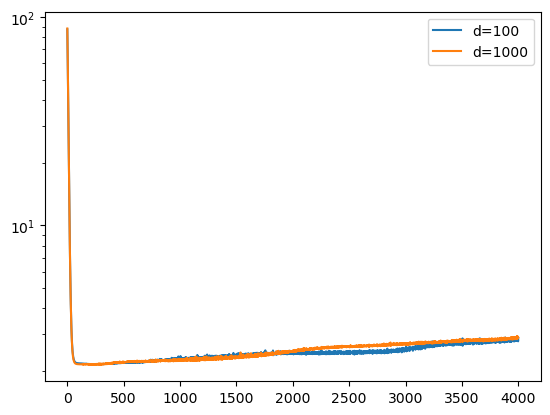

In [48]:
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.2,b=0.2)
        m.bias.data.fill_(0.01)
        
### data
n=1000
plist=[100,1000]
losslist=[]
for p in plist:
    rff1=RandomFourierFeature(p,10,kernel='G',gamma=0.5)
    rff2=RandomFourierFeature(10,10,kernel='G',gamma=1)
    rff3=RandomFourierFeature(10,10,kernel='G',gamma=2)
    rff4=RandomFourierFeature(10,10,kernel='G',gamma=4)

    class KernelNet(nn.Module): 
        def __init__(self):
            super(KernelNet, self).__init__()
            self.fc1 = nn.Linear(10, 10)
            self.fc2 = nn.Linear(10, 10)
            self.fc3 = nn.Linear(10, 10)
            self.fc4 = nn.Linear(10, 1)
            
        def forward(self, x):
            x = rff1.transform(x)
            x=self.fc1(x)
            x = rff2.transform(x)
            x=self.fc2(x)
            x = rff3.transform(x)
            x=self.fc3(x)
            x = rff4.transform(x)
            return self.fc4(x)
        
        
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) 

    kernelnn_model=MultilayerFitting(net,device,train_loader, 4000, criterion, optimizer,2000)
    kernelnn_trainloss,kernelnn_testloss,prediction=kernelnn_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(kernelnn_trainloss[-1],kernelnn_testloss[-1]))
    losslist.append(kernelnn_testloss[-1])
    plt.plot(kernelnn_testloss,label="d={:d}".format(p))
    plt.yscale('log')
plt.legend()
plt.show()
mse_high_result['MLKM']=losslist

## 4. RKM

d=100
epoch 0
                    Train set - loss: 42.997552903885584
                    Test  set - loss: 42.65994120302427
                    
epoch 500
                    Train set - loss: 1.6900144948538942
                    Test  set - loss: 2.4959302156999295
                    
epoch 1000
                    Train set - loss: 1.5461221732130448
                    Test  set - loss: 2.664332263991708
                    
epoch 1500
                    Train set - loss: 1.488035694088187
                    Test  set - loss: 2.761209621872195
                    
epoch 2000
                    Train set - loss: 1.3555995953209063
                    Test  set - loss: 2.8398745114065886
                    
epoch 2500
                    Train set - loss: 1.2805475467126053
                    Test  set - loss: 2.959951069691619
                    
epoch 3000
                    Train set - loss: 1.3346056569662998
                    Test  set - loss: 2.9207249976540437
  

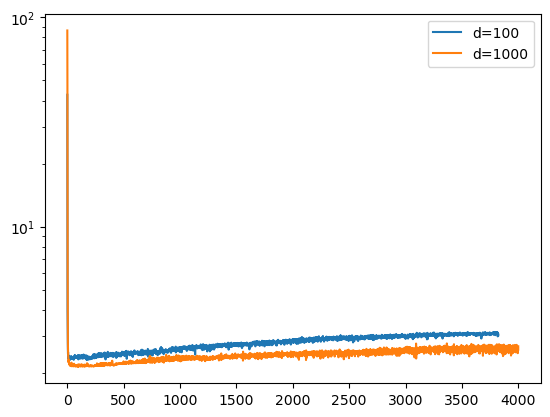

In [37]:
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.2,b=-0.2)
        m.bias.data.fill_(0.01)
        
### data
n=1000
plist=[100,1000]
losslist=[]
for p in plist:
    rff0=RandomFourierFeature(p,10,kernel='G',gamma=0.5)
    rff1=RandomFourierFeature(10,10,kernel='G',gamma=1)
    rff2=RandomFourierFeature(10,10,kernel='G',gamma=2)
    rff3=RandomFourierFeature(10,10,kernel='G',gamma=4)

    class ResidualBlock(nn.Module):
        def __init__(self,infeatures,outfeatures,rff):
            super(ResidualBlock,self).__init__()
            self.infeatures = infeatures
            self.outfeatures = outfeatures
            self.rff=rff
            
            self.fc1 = nn.Linear(infeatures,outfeatures)
            self.fc2 = nn.Linear(outfeatures,outfeatures)
        
        def forward(self, x):
            rff=self.rff
            x = self.fc1(x)
            y = rff.transform(x)
            y = self.fc2(y)
            return x+y

    class ResKernelNet(nn.Module): 
        def __init__(self):
            super(ResKernelNet, self).__init__()
            self.rblock1 = ResidualBlock(10,10,rff1)
            self.rblock2 = ResidualBlock(10,10,rff2)
            self.rblock3 = ResidualBlock(10,10,rff3)
            self.fc4 =nn.Linear(10,1)
    
        def forward(self, x):
            x = rff0.transform(x)
            x = self.rblock1(x)
            x = self.rblock2(x)
            x = self.rblock3(x)
            return self.fc4(x)
    
    
    print("d={:d}".format(p))
    np.random.seed(0)
    data = np.random.uniform(0,1, (n,p)) #n points
    y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            y[i]=y[i]+data[i][j]+2*np.exp(-16*data[i][j]**2)
    
            
    train_x=data
    train_y=y
    nntrain_x = torch.from_numpy(train_x).float()
    nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
    
    np.random.seed(1)
    test_x = np.random.uniform(0,1, (n,p)) #n points
    test_y=np.zeros(n)
    for i in range(n):
        for j in range(min(p,10)):
            test_y[i]=test_y[i]+test_x[i][j]+2*np.exp(-16*test_x[i][j]**2)
    

    train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) 

    reskernel_model=MultilayerFitting(net,device,train_loader, 4000, criterion, optimizer,2000)
    reskernel_trainloss,reskernel_testloss,prediction=reskernel_model.fitting(train_x,train_y,test_x,test_y)
    print('Train loss: {:.4e}, Test loss: {:.4e}'.format(kernelnn_trainloss[-1],reskernel_testloss[-1]))
    losslist.append(reskernel_testloss[-1])
    plt.plot(reskernel_testloss,label="d={:d}".format(p))
    plt.yscale('log')
plt.legend()
plt.show()
mse_high_result['RKM']=losslist

In [49]:
mse_high_result

,DNN,ResNet,MLKM,RKM
d=100,3.416614,3.148152,2.881230,3.041097
d=1000,2.971171,2.818057,2.896494,2.694135
